## Detailed Age investigation

TODO:
- [ ] Redo the naive approach for 100, 120, 140 for single members
- use the age from the volume data for outside OMZ values (test for sensitivity to lat and depth)
- Preserve Depth as dimension (and give dz_t as coordinate so integration later is possible)

In [1]:
# quick check for the age 'around' the OMZ with time from the histogram data
import pathlib
import xarray as xr

zkwargs = {"use_cftime": True, "consolidated": True}


# Pre-pre processed volume data (TODO streamline)
path = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.2/')
flist = list(path.glob('*.zarr'))
datasets = [xr.open_zarr(f, **zkwargs) for f in flist]







# # drop age (if there) and make sure that all datasets have dz_
# def clean(ds):
#     for va in ['dz_t', 'agessc']:
#         if va in ds.variables:
#             ds = ds.drop(va)
            
#     return ds
# ddict_volume = concat_members(
#     {
#         cmip6_dataset_id(ds):clean(ds) for ds in datasets
#     }, concat_kwargs={'combine_attrs': 'drop_conflicts', 'coords':'minimal'}
# )
# # convert to annual means (the GFDL ones are already converted?)
# def _coarsen(ds):
#     if 'time' in ds.variables:
#         if not 'GFDL' in ds.source_id:
#             # TODO: This is weird, I need to really check on the original files and average them per year
#             ds = ds.coarsen(time=12).mean()
#     return ds

# ddict_volume = {k: _coarsen(ds) for k,ds in ddict_volume.items()}

# assert len(ddict_volume.keys()) == 15

# # assert the time length (I really need to redo these)
# for n,ds in ddict_volume.items():
#     if 'time' in ds.dims:
# #         print(f"{n} {len(ds.time)}")
#         assert len(ds.time) == 251



KeyboardInterrupt



In [1]:
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(24))

# # #trying to fix GFDL models

In [2]:
## just a quick hack. I need to get these all from the proper environment

## I somehow had to execute this in the terminal. Did not work from here
# !pip install git+https://github.com/jbusecke/cmip6_preprocessing.git
# !pip install -e /projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/.

In [3]:
# %load_ext autoreload
# %autoreload 2

import cf_xarray
import intake
import xarray as xr
import numpy as np


from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import (
    match_metrics,
    interpolate_grid_label,
    merge_variables,
    concat_experiments,
)

from cmip6_preprocessing.drift_removal import match_and_remove_trend
from fastprogress.fastprogress import progress_bar
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import (
    pick_first_member,
    construct_static_dz,
    concat_time,
    append_write_zarr,
    zarr_exists,
)
from cmip6_omz.units import convert_mol_m3_mymol_kg

from xarrayutils.file_handling import maybe_create_folder

### needs cleaning
from cmip6_omz.omz_tools import omz_thickness_efficient, mask_basin
import matplotlib.pyplot as plt
from cmip6_omz.upstream_stash import append_write_zarr

from dask.diagnostics import ProgressBar

In [4]:
# import hvplot.xarray
# import panel.widgets as pnw

In [5]:
from xarrayutils.file_handling import maybe_create_folder

# Global Parameters
hist_slice = slice('1950', '2000')
scen_slice = slice('2050', '2075')

ifolder = maybe_create_folder('../data/interim/outer_age_timeseries_thresholds')
# ifolder2 = maybe_create_folder('../data/interim/outer_age_timeseries_simple')
# ifolder3 = maybe_create_folder('../data/interim/outer_age_timeseries_simple_full_depth')

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xarrayutils/file_handling.py:118: UserWarning: Folder ../data/interim/outer_age_timeseries_thresholds does already exist.
  warnings.warn(f"Folder {path} does already exist.", UserWarning)


In [6]:
col = cmip6_collection(zarr=False)
kwargs = dict(
    aggregate=False,
    zarr_kwargs={"decode_times": True, "use_cftime": True, "consolidated": True},
    cdf_kwargs={"decode_times": True, "use_cftime": True, "chunks": {"time": 1}},
    preprocess=combined_preprocessing,
)

variable_ids = ["thetao", "so", "o2", "agessc"]  # "mlotst"
metric_variable_ids = ["thkcello", "areacello"]  # "mlotst"

models = [
    "ACCESS-ESM1-5",#had some issue
    "CanESM5-CanOE",
    "NorESM2-LM",
    'NorESM2-MM',
    'MIROC-ES2L',
    "CanESM5", 
    "GFDL-ESM4",
    "GFDL-CM4",
    'UKESM1-0-LL',
]

cat = col.search(
    source_id=models,
    grid_label=["gr", "gn"],
    experiment_id=["historical", "ssp585"],
    table_id=["Omon"],
    variable_id=variable_ids,
)
ds_dict = cat.to_dataset_dict(**kwargs)

# make a separate metric dict to catch all possible metrics!
cat_metrics = col.search(source_id=models, variable_id=metric_variable_ids)
ds_metric_dict = cat_metrics.to_dataset_dict(**kwargs)

# combine in time (only needed for netcdf collection)
ds_dict = concat_time(ds_dict)
ds_metric_dict = concat_time(ds_metric_dict)



####### Brute Force add the GFDL age
# TODO: Make this nicer with the original netcdf files (not tonight though)
col_gfdl = cmip6_collection(zarr=True)
# BUG: There is something weird going on in the reading process here
# Just drop everything that is not GFDL
df = col_gfdl.df
df = df.iloc[ ['GFDL' in i for i in df['source_id']], :]
df = df.iloc[ ['agessc' in i for i in df['variable_id']], :]
col_gfdl.df = df
cat_gfdl = col_gfdl.search(
    source_id=[
        "GFDL-CM4",
        "GFDL-ESM4",
    ],
    variable_id=["agessc"],
    experiment_id=["historical", "ssp585"],
)

ddict_gfdl_age = cat_gfdl.to_dataset_dict(**kwargs)
ddict_gfdl_age = {k:ds for k, ds in ddict_gfdl_age.items()}
ds_dict.update(ddict_gfdl_age)

# rechunk the GFDL models in depth
def maybe_rechunk(ds):
    if ds.source_id in ["GFDL-CM4"]:
        ds = ds.chunk({'lev':1})

    return ds
ds_dict = {k:maybe_rechunk(ds) for k,ds in ds_dict.items()}

Dataframe size before picking latest version: 2363
Getting latest version...

Dataframe size after picking latest version: 2258

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r29i1p1f2.Omon.gn.none.so: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp585.r4i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r6i1p1f2.Omon.gn.none.agessc: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': can

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r2i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r10i1p1f2.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r25i1p1f2.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot co

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp585.r9i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r11i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r20i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev'

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp585.r1i1p1f2.Omon.gn.none.agessc: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r11i1p1f2.Omon.gn.none.so: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp585.r6i1p1f2.Omon.gn.none.agessc: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': 

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r8i1p1f2.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r9i1p1f2.Omon.gn.none.so: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r22i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot con

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r30i1p1f2.Omon.gn.none.so: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r9i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r17i1p1f2.Omon.gn.none.agessc: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': canno

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r12i1p1f2.Omon.gn.none.so: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r7i1p1f2.Omon.gn.none.so: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r10i1p1f2.Omon.gn.none.agessc: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot co


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


## Dict Processing

In [7]:
import pathlib
# new files (change in later and get rid of `load_trend_dict` (or refactor?) and `fix_trend_metadata`)
# Load all trend files
flist = list(pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_control_drifts/').absolute().glob('*.nc'))
flist = [f for f in flist if any([v in str(f) for v in variable_ids])]
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

In [8]:
import warnings

def _expected_length(ds):
    if ds.experiment_id == "historical":
        if ds.table_id == "Omon":
            return 1980
        else:
            warnings.warn(
                f"unknown table_id [{ds.table_id}] for {cmip6_dataset_id(ds)}"
            )
            return 1

    elif "ssp" in ds.experiment_id:
        if ds.table_id == "Omon":
            return 1032
        else:
            warnings.warn(
                f"unknown table_id [{ds.table_id}] for {cmip6_dataset_id(ds)}"
            )
            return 1

    elif "Control" in ds.experiment_id:
        if ds.table_id == "Omon":
            return (
                12 * 200
            )  # just give a low number here so none of the controls are dropped
        else:
            warnings.warn(
                f"unknown table_id [{ds.table_id}] for {cmip6_dataset_id(ds)}"
            )
            return 1
    else:
        warnings.warn(
            f"unknown experiment_id [{ds.experiment_id}] for {cmip6_dataset_id(ds)}"
        )
        return 1


def filter_ddict(ddict):
    ddict_filtered = {}
    for name, ds in ddict.items():
        # drop everything but main variable
        ds = ds.drop([v for v in ds.data_vars if v != ds.variable_id])

        # filter out too short runs
        if "time" not in ds.dims:
            ddict_filtered[name] = ds
        else:
            if len(ds.time) < _expected_length(ds):
                print("---------DROPPED--------")
                print(name)
                print(_expected_length(ds))
                print(len(ds.time))
                print("---------DROPPED--------")
            else:
                ddict_filtered[name] = ds
    return ddict_filtered


# apply to data and metrics
ds_dict_filtered = filter_ddict(ds_dict)
ds_metric_dict_filtered = filter_ddict(ds_metric_dict)

---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r7i1p1f1.thkcello
1032
312
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r25i1p1f1.thkcello
1032
312
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r17i1p1f1.thkcello
1032
360
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r16i1p1f1.thkcello
1032
360
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r21i1p1f1.thkcello
1032
120
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r13i1p1f1.thkcello
1032
360
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r19i1p1f1.thkcello
1032
120
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r12i1p1f1.thkcello
1032
120
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5.gn.ssp245.Omon.r18i1p1f1.thkcello
1032
240
---------DROPPED--------
---------DROPPED--------
ACCESS-ESM1-5

In [9]:
# these ones are messed up...need a better way to deal with that in the previous step
# see https://github.com/jbusecke/cmip6_preprocessing/issues/175
incomplete_keys = ['CMIP.IPSL.IPSL-CM6A-LR.historical.r3i1p1f1.Omon.gn.none.area_o2']
trend_dict = {k:ds for k,ds in trend_dict.items() if k not in incomplete_keys}
# i think this should be taken care of in the filtering step above...TODO check at a later point

ddict_tracers_detrended = match_and_remove_trend(
    ds_dict_filtered,
    trend_dict,
)

# these cause trouble
problem_metrics = [
    'ACCESS-ESM1-5.gn.ssp585.Omon.r3i1p1f1.thkcello', # metric too short
    'ACCESS-ESM1-5.gn.ssp585.Omon.r2i1p1f1.thkcello', # metric too short
    'ACCESS-ESM1-5.gn.ssp585.Omon.r1i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r9i1p1f1.thkcello', # metric too short
    'ACCESS-ESM1-5.gn.ssp585.Omon.r6i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r4i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r8i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r10i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r5i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
]
for key in problem_metrics:
    if key in ds_metric_dict_filtered.keys():
        del ds_metric_dict_filtered[key]
        
# this one causes problems because the time is not as long as the full data...apparently they stopped writing the thickness
# ddict_tracers_detrended_filtered = {
#     k: ds.squeeze()
#     for k, ds in ddict_tracers_detrended.items()
#     if not ("ACCESS-ESM1-5" in k and "r3i1p1f1" in k)
# }

ddict_matched = match_metrics(
    ddict_tracers_detrended,
    ds_metric_dict_filtered,
    ["areacello", "thkcello"],
    print_statistics=True,
)

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r18i1p1f1.Omon.gn.v20200803.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r25i1p1f1.Omon.gn.v20190429.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r17i1p1f1.Omon.gn.v20190429.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r29i1p1f1.Omon.gn.v2

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r22i1p1f1.Omon.gn.v20190429.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MOHC.UKESM1-0-LL.historical.r12i1p1f2.Omon.gn.none.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r18i1p1f1.Omon.gn.v20190429.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r7i1p1f1.Omon.gn.v20

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r21i1p1f1.Omon.gn.v20190429.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r30i1p2f1.Omon.gn.v20190429.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r21i1p1f1.Omon.gn.v20200922.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.gn.v2

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r12i1p1f1.Omon.gn.v20200803.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Omon.gn.none.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Omon.gn.none.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r28i1p1f1.Omon.gn.v2020092

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.NCC.NorESM2-MM.ssp585.r1i1p1f1.Omon.gn.none.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1.Omon.gn.v20200803.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorESM2-MM.historical.r1i1p1f1.Omon.gn.none.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r24i1p1f1.Omon.gn.v20190429.s

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r14i1p1f1.Omon.gn.v20200803.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r28i1p1f2.Omon.gn.none.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1.Omon.gn.v20200803.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r19i1p1f1.Omon.g

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r16i1p1f1.Omon.gn.v20200803.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.Omon.gn.v20200803.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r25i1p1f2.Omon.gn.none.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.g

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r19i1p1f2.Omon.gn.none.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r1i1000p1f2.Omon.gn.none.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r14i1p1f2.Omon.gn.none.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r14i1p1f2.Omon.gn.none.th

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r22i1p1f2.Omon.gn.none.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NIMS-KMA.UKESM1-0-LL.historical.r13i1p1f2.Omon.gn.none.o2
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r12i1p1f2.Omon.gn.none.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MIROC.MIROC-ES2L.historical.r1i1000p1f2.Omon.gn.none.o2

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:636: UserWarning: This metric had a time dimension and did not perfectly match. Not parsing anything.
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:615: UserWarning: No matching metrics found for areacello
  warnings.warn(f"No matching metrics found for {mv}")
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:615: UserWarning: No matching metrics found for thkcello
  warnings.warn(f"No matching metrics found for {mv}")


Processed 469 datasets.
Exact matches:{'areacello': 0, 'thkcello': 60}
Other matches:{'areacello': 442, 'thkcello': 267}
No match found:{'areacello': 27, 'thkcello': 80}


In [10]:
print("interpolate grids\n")
ddict_matched_regrid = interpolate_grid_label(
    ddict_matched, merge_kwargs={"compat": "override"}
)  # This should be a default soon

interpolate grids



/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  ret

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter.

In [11]:
ddict_ex_combined = concat_experiments(
    ddict_matched_regrid,
    concat_kwargs={
        'combine_attrs': 'drop_conflicts',
        'compat': 'override',
        'coords': 'minimal'
    }
)

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [12]:
# only pick full runs (historical and ssp585)
ddict_ex_combined_full = {k:ds for k,ds in ddict_ex_combined.items() if len(ds.time)>3000}

In [28]:
sorted(list(ddict_ex_combined_full.keys()))

['ACCESS-ESM1-5.gn.Omon.r10i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r1i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r2i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r3i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r4i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r5i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r6i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r8i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r9i1p1f1',
 'CanESM5-CanOE.gn.Omon.r1i1p2f1',
 'CanESM5-CanOE.gn.Omon.r2i1p2f1',
 'CanESM5-CanOE.gn.Omon.r3i1p2f1',
 'CanESM5.gn.Omon.r10i1p1f1',
 'CanESM5.gn.Omon.r10i1p2f1',
 'CanESM5.gn.Omon.r1i1p1f1',
 'CanESM5.gn.Omon.r1i1p2f1',
 'CanESM5.gn.Omon.r2i1p1f1',
 'CanESM5.gn.Omon.r2i1p2f1',
 'CanESM5.gn.Omon.r3i1p1f1',
 'CanESM5.gn.Omon.r3i1p2f1',
 'CanESM5.gn.Omon.r4i1p1f1',
 'CanESM5.gn.Omon.r4i1p2f1',
 'CanESM5.gn.Omon.r5i1p1f1',
 'CanESM5.gn.Omon.r5i1p2f1',
 'CanESM5.gn.Omon.r6i1p1f1',
 'CanESM5.gn.Omon.r6i1p2f1',
 'CanESM5.gn.Omon.r7i1p1f1',
 'CanESM5.gn.Omon.r7i1p2f1',
 'CanESM5.gn.Omon.r8i1p1f1',
 'CanESM5.gn.Omon.r8i1p2f1',
 'CanESM5.gn.Omon.r9i1p1f1',
 'CanESM5.gn.Omon.r9i1p2f1

In [29]:
from cmip6_preprocessing.grids import combine_staggered_grid
problems = {'missing_variables':[], 'missing_area':[], 'missing_thickness':[], 'reconstructed_area':[], 'reconstructed_thickness':[]}
ddict_filtered = {}
for name, ds in ddict_ex_combined_full.items():
    flag = False
    # Check that all necessary variables are given
    missing_variables = [va for va in ["thetao", "so", "o2"] if va not in ds.variables]
    if len(missing_variables)>0:
        flag = True
        problems['missing_variables'].append((name, missing_variables))
        
    # Check for area
    if not 'areacello' in ds.coords:
        if ds.attrs['grid_label'] == 'gr': # only reconstruct for regular grids
            grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)
            # I am dropping dz_t here so it can be uniformly reconstructed
            ds = ds.drop('dz_t')
            ds = ds.assign_coords(areacello = (ds.dx_t * ds.dy_t).reset_coords(drop=True))
            problems['reconstructed_area'].append(name)
            assert 'areacello' in ds.coords
        else:
            flag = True
            problems['missing_area'].append(name)
    
    # Check for thickness (and rename) TODO: We should probably not rename and just refactor to use `thkcello`
    if "thkcello" in ds.coords:
        ds = ds.rename({'thkcello': 'dz_t'})
    else:
        # try to reconstruct the thickness from static info
        try:
#             lev_vertices = cf_xarray.bounds_to_vertices(ds.lev_bounds, 'bnds').load()
#             dz_t = lev_vertices.diff('lev_vertices')
#             ds = ds.assign_coords(dz_t=('lev', dz_t.data))
            ds = construct_static_dz(ds).rename({'thkcello': 'dz_t'})
            problems['reconstructed_thickness'].append(name)
        except Exception as e:
            print(f'{name} thickness reconstruction failed with {e}')
            print(ds)
            problems['missing_thickness'].append(name)
            flag=True
            
    if not flag:
        ddict_filtered[name] = ds
problems

{'missing_variables': [('ACCESS-ESM1-5.gn.Omon.r10i1p1f1', ['thetao'])],
 'missing_area': [],
 'missing_thickness': [],
 'reconstructed_area': ['NorESM2-MM.gr.Omon.r1i1p1f1',
  'NorESM2-LM.gr.Omon.r1i1p1f1'],
 'reconstructed_thickness': ['ACCESS-ESM1-5.gn.Omon.r1i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r9i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r8i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r3i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r4i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r10i1p1f1',
  'MIROC-ES2L.gn.Omon.r4i1p1f2',
  'MIROC-ES2L.gn.Omon.r6i1p1f2',
  'MIROC-ES2L.gn.Omon.r5i1p1f2',
  'ACCESS-ESM1-5.gn.Omon.r5i1p1f1',
  'MIROC-ES2L.gn.Omon.r10i1p1f2',
  'MIROC-ES2L.gn.Omon.r8i1p1f2',
  'MIROC-ES2L.gn.Omon.r7i1p1f2',
  'MIROC-ES2L.gn.Omon.r2i1p1f2',
  'MIROC-ES2L.gn.Omon.r1i1p1f2',
  'MIROC-ES2L.gn.Omon.r9i1p1f2',
  'MIROC-ES2L.gn.Omon.r3i1p1f2']}

In [31]:
ddict_filtered = pick_first_member(ddict_filtered)
ddict_filtered = {k:ds for k,ds in ddict_filtered.items() if 'agessc' in ds.variables}

In [34]:
list(ddict_filtered.keys())

['ACCESS-ESM1-5.gn.Omon',
 'NorESM2-MM.gr.Omon',
 'CanESM5.gn.Omon',
 'CanESM5-CanOE.gn.Omon',
 'GFDL-ESM4.gn.Omon',
 'GFDL-CM4.gn.Omon',
 'NorESM2-LM.gr.Omon',
 'MIROC-ES2L.gn.Omon']

## Simplyfied try (redundant)
This can be done with the histogram processed data, do it over there

In [35]:
# def age_without_omz(ds, o2_threshold):
# #     depth_range = slice(0, 2000)    
# #     ds = ds.sel(lev=depth_range)

#     age = ds.agessc
#     o2 = ds.o2

#     vol = (ds.dz_t * ds.areacello).load()
#     # in some models the volume is inf? GFDL mainly. What is this TODO: Investigate this further...
#     vol = vol.fillna(0).where(np.isfinite(vol), 0)


#     mask = mask_basin(age, drop=False).fillna(0).where(abs(age.lat) <= 30, 0)
#     age = age.where(mask)
#     age = age.where(convert_mol_m3_mymol_kg(o2)>=o2_threshold)

# #     age.attrs['depth range'] = f"{depth_range.start}_{depth_range.stop}"
#     age.attrs['o2_threshold'] = str(o2_threshold)
#     age_timeseries = age.weighted(vol).mean(['x', 'y', 'lev'])
#     return age_timeseries.to_dataset(name='age_simple')

In [36]:
# # loop over all datasets
# age_timeseries = {}
# overwrite=True

# o2_threshold = 100
# for o2_threshold in [100, 120, 140]:
#     for n, ds in ddict_filtered.items():
#         print(n)
#         filepath = ifolder3.joinpath(f"{cmip6_dataset_id(ds)}_outer_age_timeseries_simple_o2_{o2_threshold}.zarr")
#         if zarr_exists(filepath) and not overwrite:
#             print('exists')
#         else:
#             timeseries = age_without_omz(ds, o2_threshold)

#             # TEMP: I had some issues with the longer ACCESS one
#             timeseries = timeseries.sel(time=slice('1850', '2100'))
#             append_write_zarr(timeseries, filepath, 30)

#         timeseries_control = xr.open_zarr(filepath, use_cftime=True, consolidated=True)

#         try:

#             plt.figure()
#             timeseries_control.age_simple.plot()
#             plt.show()


#         except Exception as e:
#             print(f'Plotting failed due to {e}')

## Outer Age increase

- Check difference between 'expansion only' and 'xor' mask ✅ The xor mask seems to show the same thing but is more 'fair'?
- Do we want to limit this to 30S-30N?

In [38]:
def outer_age_timeseries(ds, o2_threshold):
    print('Loading Volume')
    vol = (ds.dz_t * ds.areacello)
    # in some models the volume is inf? GFDL mainly. What is this TODO: Investigate this further...
    vol = vol.fillna(0).where(np.isfinite(vol), 0)
    
    print('Define Means')
    ds_hist = ds.sel(time=hist_slice).mean('time')
    ds_scen = ds.sel(time=scen_slice).mean('time')
    
    o2_hist = ds_hist.o2.to_dataset(name='o2')
    o2_scen = ds_scen.o2.to_dataset(name='o2')
    
    file_o2_hist = ifolder.joinpath('temp/o2_hist.zarr')
    file_o2_scen = ifolder.joinpath('temp/o2_scen.zarr')
    
    print('Computing means')
    lev_split = 1 if 'CM4' in ds.source_id else 100
    append_write_zarr(o2_hist, file_o2_hist, lev_split, split_dim='lev')
    append_write_zarr(o2_scen, file_o2_scen, lev_split, split_dim='lev')
    
        
    o2_hist = convert_mol_m3_mymol_kg(xr.open_zarr(file_o2_hist).o2)
    o2_scen = convert_mol_m3_mymol_kg(xr.open_zarr(file_o2_scen).o2)
    
    print('Creating Mask')
    mask_hist = o2_hist<=o2_threshold
    mask_scen = o2_scen<=o2_threshold
    mask_change = np.logical_xor(mask_scen, mask_hist)
    mask = mask_change
    
    #restrict mask to the pacific tropics
    mask = mask_basin(mask, drop=False).fillna(0).where(abs(mask.lat) <= 30, 0)
    
    print('Final Step')
    p = ds.agessc.where(mask).weighted(vol).mean(['x','y', 'lev'])
    p = p.to_dataset(name='agessc') 
    attrs = {k:v for k,v in ds.attrs.items() if k not in ['intake_esm_varname']}
    p.attrs = attrs
    p = p.assign_coords(mask=mask, o2_threshold=o2_threshold)
    return p

ACCESS-ESM1-5.gn.Omon
exists


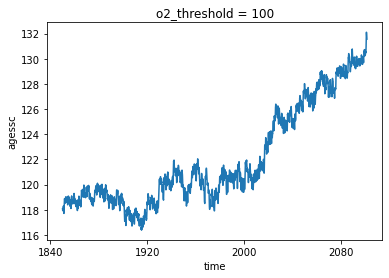

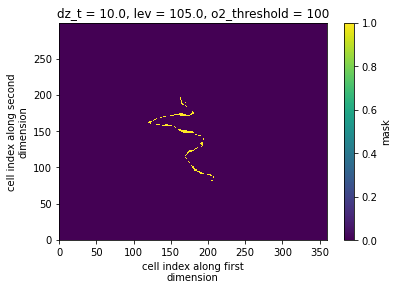

NorESM2-MM.gr.Omon
exists


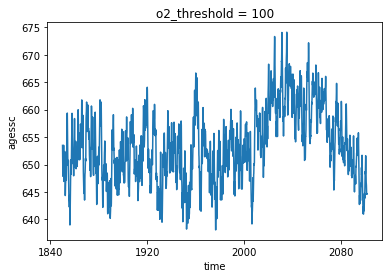

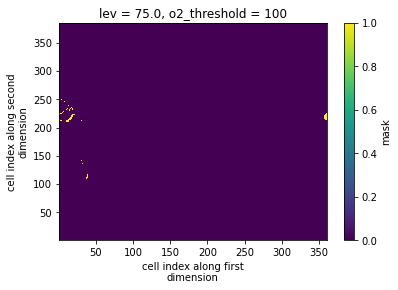

CanESM5.gn.Omon
exists


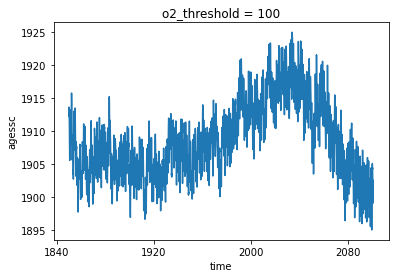

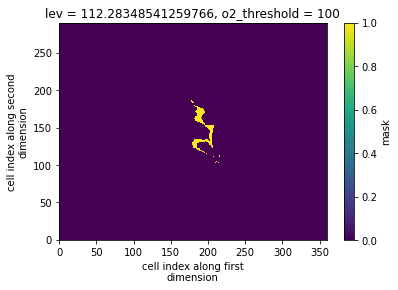

CanESM5-CanOE.gn.Omon
exists


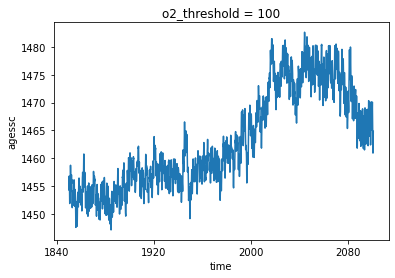

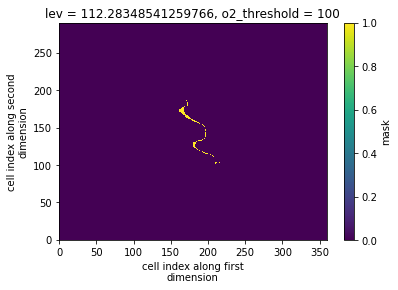

GFDL-ESM4.gn.Omon
exists


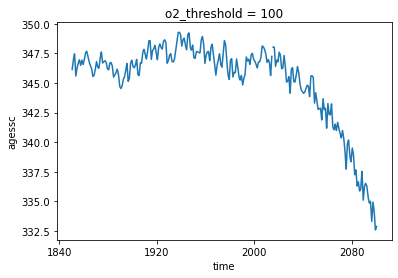

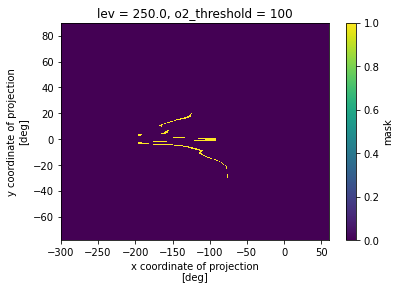

GFDL-CM4.gn.Omon
exists


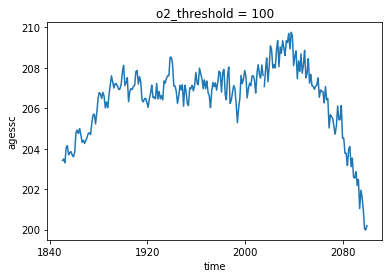

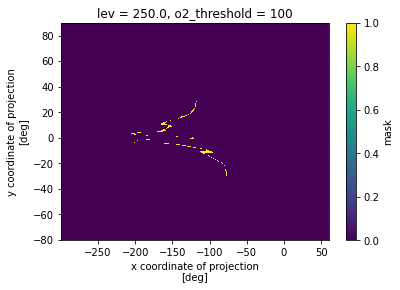

NorESM2-LM.gr.Omon
exists


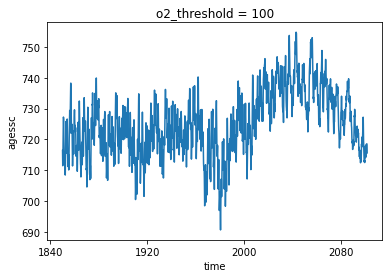

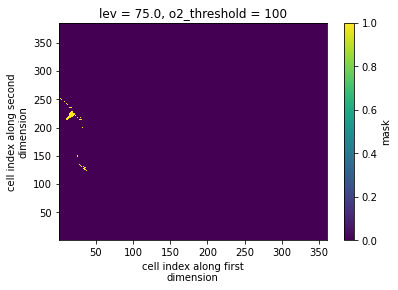

MIROC-ES2L.gn.Omon
exists


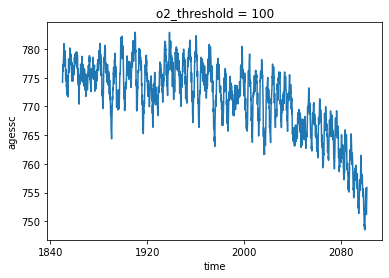

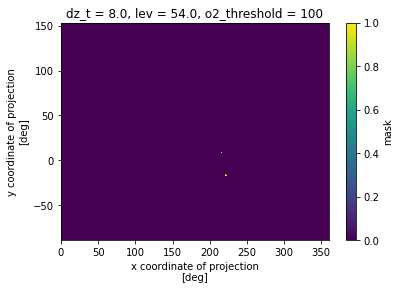

ACCESS-ESM1-5.gn.Omon
Loading Volume
Define Means
Computing means


In [ ]:
# loop over all datasets
age_timeseries = {}
overwrite=False

for o2 in [100, 120, 140]:
    for n, ds in ddict_filtered.items():
        print(n)
        filepath = ifolder.joinpath(f"{cmip6_dataset_id(ds)}_outer_age_timeseries_{o2}.zarr")
        if zarr_exists(filepath) and not overwrite:
            print('exists')

        else:
            timeseries = outer_age_timeseries(ds, o2)

            # TEMP: I had some issues with the longer ACCESS one
            timeseries = timeseries.sel(time=slice('1850', '2100'))
            append_write_zarr(timeseries, filepath, 30)

        age_timeseries[n] = xr.open_zarr(filepath, use_cftime=True, consolidated=True)

        try:

            plt.figure()
            age_timeseries[n].agessc.plot()
            plt.show()

            plt.figure()
            age_timeseries[n].mask.isel(lev=10).plot()
            plt.show()


        except Exception as e:
            print(f'Plotting failed due to {e}')

In [21]:
ds

<xarray.Dataset>
Dimensions:        (time: 3012, lev: 75, y: 330, x: 360, bnds: 2, vertex: 4)
Coordinates: (12/14)
  * time           (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
  * lev            (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds     (lev, bnds) float64 0.0 1.024 1.024 ... 5.8e+03 6.004e+03
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 322 323 324 325 326 327 328 329
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    ...             ...
    lat_verticies  (y, x, vertex) float32 -84.16 -84.06 -84.06 ... 50.0 49.98
    lon_verticies  (y, x, vertex) float32 73.0 73.0 74.0 74.0 ... 73.0 73.0 73.0
    lon_bounds     (bnds, y, x) float32 73.0 74.0 75.0 76.0 ... 72.95 72.97 73.0
    lat_bounds     (bnds, y, x) float32 -84.16 -84.16 -84.16 ... 50.24 50.05
    areacello      (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    dz_t           (time, lev, y, x) float32 dask.array<chunksize=(1, 75, 330, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    thetao         (time, lev, y, x) float64 dask.array<chunksize=(1, 75, 330, 360), meta=np.ndarray>
    o2             (time, lev, y, x) float64 dask.array<chunksize=(1, 75, 330, 360), meta=np.ndarray>
    so             (time, lev, y, x) float64 dask.array<chunksize=(1, 75, 330, 360), meta=np.ndarray>
Attributes: (12/35)
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         standard
    cv_version:            6.2.20.1
    data_specs_version:    01.00.29
    external_variables:    areacello volcello
    forcing_index:         2
    ...                    ...
    title:                 UKESM1-0-LL output prepared for CMIP6
    variant_label:         r1i1p1f2
    license:               CMIP6 model data produced by the Met Office Hadley...
    cmor_version:          3.4.0
    intake_esm_varname:    None
    original_key:          UKESM1-0-LL.gn.Omon.r1i1p1f2

In [ ]:
stop here

# Test with xor mask
Decided to keep the xor mask

In [ ]:
# simple try first, only the expanding regions (later try xor)
mask_hist = np.logical_and(o2_hist>=100, o2_hist<=140)
mask_scen = np.logical_and(o2_scen>=100, o2_scen<=140)
mask_grow = ~np.logical_xor(mask_scen, ~mask_hist)

mask = mask_basin(mask_grow, drop=False).fillna(0).where(abs(mask_grow.lat) <= 30, 0)

In [ ]:
# mask.plot(col='lev', col_wrap=2)

In [ ]:
with ProgressBar():
    p_xor = ds.agessc.where(mask).weighted(vol).mean(['x','y', 'lev']).load()

In [ ]:
p.plot()
p_xor.plot()

In [ ]:
age = ds_diff.agessc.load()
o2 = convert_mol_m3_mymol_kg(ds_diff.o2.load())
o2_hist = convert_mol_m3_mymol_kg(ds.o2.sel(time=hist_slice).load())

In [ ]:
slider = pnw.IntSlider(name='lev', start=0, end=2000)
age_plot = age.interactive().interp(lev=slider)
o2_plot = o2.interactive().interp(lev=slider)
o2_hist_plot = o2_hist.interactive().interp(lev=slider)

In [ ]:
o2_plot.plot()

## Make an interactive plot of age

Refactor this into a cloud notebook and share with Charles

In [ ]:
# ! mamba install hvplot -y

In [ ]:
ds = change(ddict_ex_combined_full['GFDL-ESM4.gn.Omon.r1i1p1f1'])
age = ds.agessc.load()
o2 = ds.o2.load()

In [ ]:
o2

In [ ]:
len(o2.lev)

This is soooo frustrating! I am apparently too stupid to understand hvplot or holoviews. It is incredibly easy to make a simple plot, but then it is just impossible to combine them into something actually useful for me...There are no docstrings that would help. GRRRRRR

In [ ]:
slider = pnw.IntSlider(name='lev', start=0, end=2000)

In [ ]:
age.interactive().interp(lev=slider).hvplot() + (age*10).interactive().interp(lev=slider).hvplot(kind='contour', color='k')

In [ ]:
da.interactive(width=900).sel(x=pnw.DiscreteSlider).plot(robust=True, yincrease=False)

In [ ]:
da.interactive().sel(y=pnw.DiscreteSlider).plot(robust=True, yincrease=False)